# Multinomial Naive Bayes
We will build NB model using the preprocessed dataset `data/2-imdb-movie-review-processed.csv` that we had created previously in EDA & preprocessing.

## Importing Processed Dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# The final preprocessed files for building the models.
processed_dataset_path = 'data/2-imdb-movie-review-processed.csv'

# Save the transformed TF-IDF vectorized data into pickle format for loading into REST API.
pickle_vectorizer_model_path = 'models/vectorized-model.pkl'

# Save the trained model into pickle format for loading into REST API.
pickle_ml_model_path = 'models/nb-ml-model.pkl'

data = pd.read_csv(processed_dataset_path)
data.head()

,review,sentiment
0,reviewer mention watch oz episode hook right e...,1
1,wonderful little production filming technique ...,1
2,I think wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


## Data Split

Class counter (stratified):
Entire-set  : Counter({1: 25000, 0: 25000}).
Train-set   : Counter({1: 20000, 0: 20000}).
Test-set    : Counter({0: 5000, 1: 5000}).


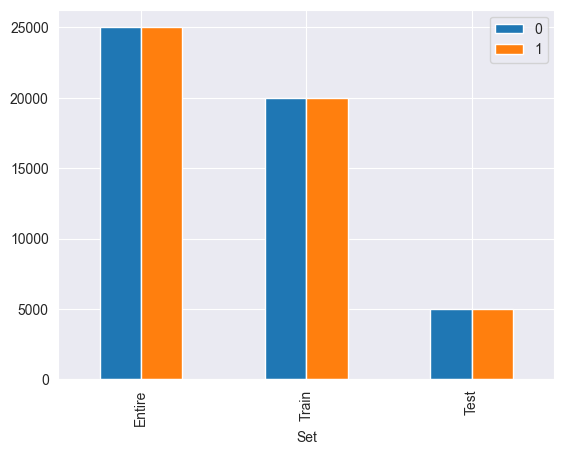

In [3]:
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold

# Randomness to reproduce same splits for comparisons.
random_state = 42

# K-fold split for cv.
kfold_n_split = 5

# K-fold shuffle for cv.
kfold_shuffle = True

# A stratified K fold for cross-validation strategy - values are assigned from the evaluation helper module.
# When random state is enabled, shuffle has to be enabled to. Shuffle is done before the deterministic split (sklearn doc).
skfolds = StratifiedKFold(n_splits=kfold_n_split,
                          shuffle=kfold_shuffle,
                          random_state=random_state)

# Define features (X) and target (y)
X = data["review"]  # Use processed text column
y = data["sentiment"]  # Target labels (0 or 1)

train_test_split(X, y, test_size=0.20, stratify=y, random_state=random_state)

# Split dataset into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=random_state)

# Display the counter for '1' and '0' in y set before splitting.
print('Class counter (stratified):')
print(f'Entire-set  : {Counter(y)}.')
print(f'Train-set   : {Counter(y_train)}.')
print(f'Test-set    : {Counter(y_test)}.')

std_y_data = [['Entire', Counter(y).get(0), Counter(y).get(1)],
              ['Train', Counter(y_train).get(0), Counter(y_train).get(1)],
              ['Test', Counter(y_test).get(0), Counter(y_test).get(1)]]

pd.DataFrame(std_y_data, columns=['Set', '0', '1']).set_index('Set').plot.bar();

# TF-IDF Vectorization (Feature Extraction)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. Otherwise, all features are used.
# Limits the max words used for building the model.
max_features = 50000

# TODO: Afif, please confirm and justify!
# Initialize TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=max_features)

# Fit TF-IDF on cleaned training data
vectoriser.fit(X_train)

print('Vectoriser fitted.')
print('No. of feature words:', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature words: 50000


#### Save the vectorized data into Pickle

In [5]:
# Save the vectorized data into pickle file format for REST API deployment.
pickle.dump(vectoriser, open(pickle_vectorizer_model_path, 'wb'))

In [6]:
# Verify the loaded model's function (ngram).
tf_idf_vector = pickle.load(open(pickle_vectorizer_model_path, 'rb'))
print(tf_idf_vector)

TfidfVectorizer(max_features=50000, ngram_range=(1, 2))


In [7]:
# Apply transformation to convert text to TF-IDF vectors
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

print('Data Transformed.')

Data Transformed.


# Base Multimonimial Naive Bayes Model

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Train the Naïve Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Weighted for class imbalance
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-score: {f1:.4f}")

# Print classification report
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred))

✅ Accuracy: 0.8689
✅ Precision: 0.8690
✅ Recall: 0.8689
✅ F1-score: 0.8689

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5000
           1       0.86      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## Base Model Confusion Matrics


🔹 Confusion Matrix:
[[4303  697]
 [ 614 4386]]


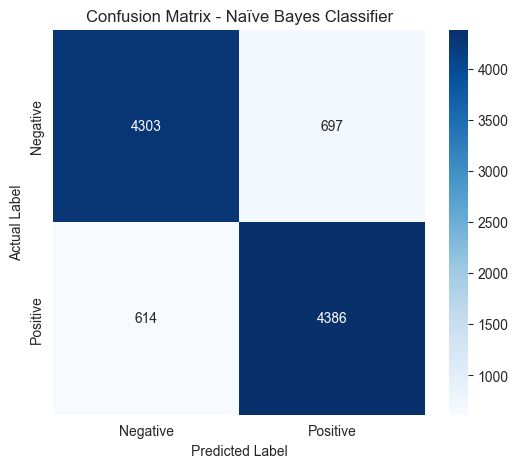

In [9]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n🔹 Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Naïve Bayes Classifier")
plt.show()

# Multinomial Naive Bayes Hyper Parameter Tuning

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define parameter grid for tuning
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

# Set up grid search with 5-fold cross-validation
grid_search = GridSearchCV(MultinomialNB(), param_grid, scoring='accuracy', cv=skfolds)

# Fit grid search on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_nb = grid_search.best_estimator_

# Make predictions using the best model
y_pred_best = best_nb.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, average='weighted')
recall = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')

# Print results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-score: {f1:.4f}")

# Print classification report
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred_best))

✅ Accuracy: 0.8692
✅ Precision: 0.8693
✅ Recall: 0.8692
✅ F1-score: 0.8692

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5000
           1       0.86      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## Tuned Model Confusion Matrics


🔹 Confusion Matrix:
[[4302  698]
 [ 610 4390]]


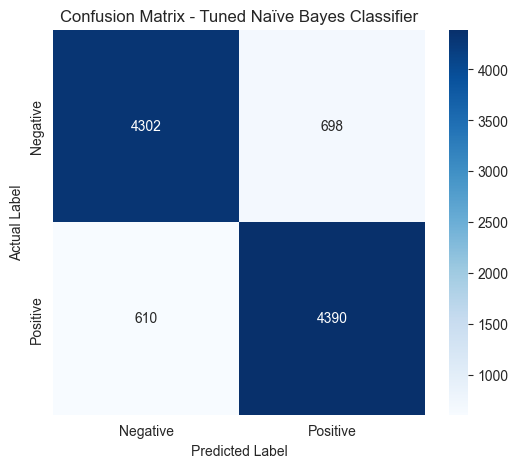

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix for the tuned model predictions
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Print confusion matrix
print("\n🔹 Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Tuned Naïve Bayes Classifier")
plt.show()

## ROC CUrve

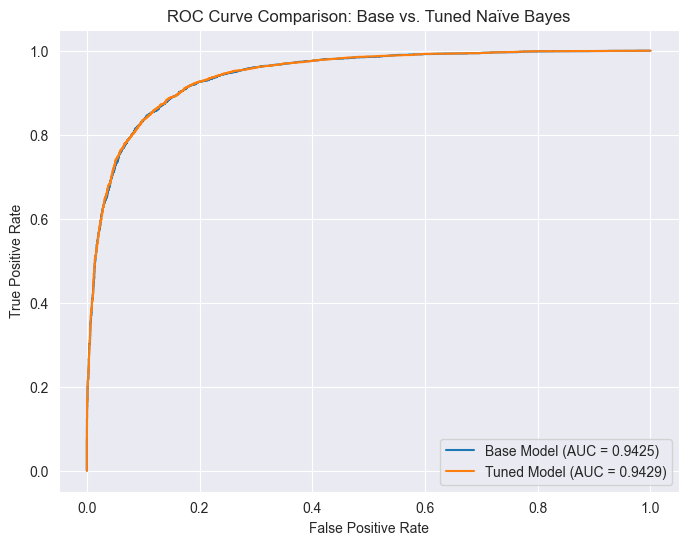

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Train the base model (if not already trained)
base_nb = MultinomialNB()
base_nb.fit(X_train, y_train)

# 2. Get predicted probabilities for the base model
y_proba_base = base_nb.predict_proba(X_test)[:, 1]

# 3. Get predicted probabilities for the tuned model
y_proba_tuned = best_nb.predict_proba(X_test)[:, 1]

# 4. Compute ROC metrics for the base model
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
auc_base = roc_auc_score(y_test, y_proba_base)

# 5. Compute ROC metrics for the tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
auc_tuned = roc_auc_score(y_test, y_proba_tuned)

# 6. Plot both ROC curves on the same figure
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f"Base Model (AUC = {auc_base:.4f})")
plt.plot(fpr_tuned, tpr_tuned, label=f"Tuned Model (AUC = {auc_tuned:.4f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Base vs. Tuned Naïve Bayes")
plt.legend()
plt.show()

## Save Best Model into Pickle
We will save the trained and tuned model into pickle file so it can be deployed later.

In [13]:
# Save the model into pickle file.
pickle.dump(best_nb, open(pickle_ml_model_path, 'wb'))

In [14]:
# Load the model to verification.
loaded_nb = pickle.load(open(pickle_ml_model_path, 'rb'))
result = loaded_nb.score(X_test, y_test)
print(result)

0.8692
